In [1]:
import sys  
sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
import networkx as nx
from scipy import sparse, linalg
import pickle
from sklearn.preprocessing import normalize, scale
from scipy.sparse import find
from numpy.linalg import norm
import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

In [2]:
size = 0 # number of nuclei to sample, use 0 value for full set
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well

In [3]:
samples = glob.glob('../data/TCGA*.gz')    

In [4]:
# Get numb of cores
num_cores = multiprocessing.cpu_count() # numb of cores

In [5]:
for dirpath in samples[:1]: # for each sample
    sample = os.path.basename(dirpath).split(sep='.')[0]; print(sample)

    print('Loading the data')
    df = pd.DataFrame()
    fovs = glob.glob(dirpath+'/*_polygon/*.svs/*.pkl')
    for fov in fovs[:2]: # for each fov
        data = pd.read_pickle(fov)
        df = df.append(data, ignore_index = True)
        #print(df.shape)

    df['area'] = df['area'].astype(float)
    
    print('With '+str(df.shape[0])+' nuclei')
    
    centroids = df.columns[:2];# print(centroids)

    if size == 0:
        print('Considering all nuclei')
        fdf = df 
    else:
        print('Downsampling '+str(size)+' nuclei')
        fdf = df.sample(n=size) 
    pos = fdf[centroids].to_numpy() # Get the positions of centroids 
    
    print('Creating the UMAP graph')
    A = space2graph(pos,nn)
    
    print('Finding the neighborhood of the sampled nodes')
    X = df[centroids].to_numpy() # the full array of position
    if size is not 0:
        n_neighbors = df.shape[0]//size + 10
    else:
        n_neighbors = 10    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',n_jobs=-1).fit(X) 
    distances, indices = nbrs.kneighbors(X) 

    #get the morphological data and rescale the data by std 
    df['area_rescaled'] = df['area'] / df['area'].mean()
    df['perimeter_rescaled'] = df['perimeter'] / df['perimeter'].mean()
    features = ['area_rescaled', 'eccentricity', 'orientation','perimeter_rescaled', 'solidity']

    data = df[features].to_numpy()
    
    # Parallel generation of the local covd
    print('Generating the descriptor')
    processed_list = Parallel(n_jobs=num_cores)(
        delayed(covd_parallel_sparse)(node,data,indices) for node in tqdm(list(fdf.index))
                                                   )    
    # Construct the descriptor array
    descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
    for r in range(len(processed_list)):
        descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
        
    # Get info about the graph
    row_idx, col_idx, values = find(A) #A.nonzero() # nonzero entries
    print('Generating the diversity index')
    node_nn_diversity_weights = Parallel(n_jobs=num_cores)(delayed(covd_gradient_parallel)(node,descriptor,row_idx,col_idx,values) for node in tqdm(range(descriptor.shape[0])))
    
    # save dataframe with pairwise diversities
    heterogeneity_df = pd.DataFrame(node_nn_diversity_weights, columns =['node', 'nn', 'diversity', 'weight']) 
    filename = './'+str(sample)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.heterogeneity.pkl'
    fdf.to_pickle(filename)

    # if you don't consider spatial weights:
    fdf['diversity'] = [np.sum(node_nn_diversity_weights[node][2]) for node in range(descriptor.shape[0])]
    # if you consider spatial weights:
    #fdf['diversity'] = [np.dot(node_nn_diversity_weights[node][2],node_nn_diversity_weights[node][3])[0] for node in range(descriptor.shape[0])]
    
    filename = './'+str(sample)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.nodeHI.pkl'
    fdf.to_pickle(filename)

    print('Generating the edge diversity index')
    #edges_list = Parallel(n_jobs=num_cores)(delayed(edge_diversity_parallel)(node,neightbors,diversity,fdf) for (node, neightbors, diversity) in tqdm(node_nn_diversity))
    edges_list = Parallel(n_jobs=num_cores)(
        delayed(edge_diversity_parallel)(node,neightbors,diversity,fdf) 
                               for (node, neightbors, diversity, weights) in tqdm(node_nn_diversity_weights)
    )
    edge_list = [item for sublist in edges_list for item in sublist]
    edge_df = pd.DataFrame(edge_list, columns=["centroid_x", "centroid_y","diversity"]) 
    filename = './'+str(sample)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.edgeHI.pkl'
    edge_df.to_pickle(filename)

TCGA-MP-A4TJ-01Z-00-DX1
Loading the data
With 9492 nuclei
Considering all nuclei
Creating the UMAP graph


  0%|          | 0/9492 [00:00<?, ?it/s]

Finding the neighborhood of the sampled nodes
Generating the descriptor


  0%|          | 0/9492 [00:00<?, ?it/s]

Generating the diversity index


  0%|          | 0/9492 [00:00<?, ?it/s]

Generating the edge diversity index


100%|██████████| 9492/9492 [00:15<00:00, 604.33it/s]


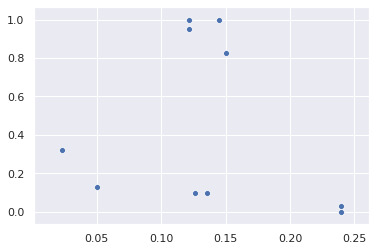

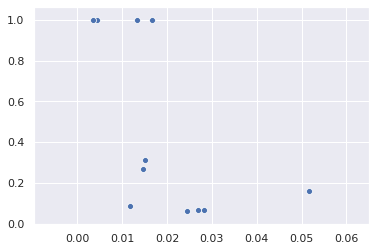

In [24]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
for ind in range(2):
    ax = sns.scatterplot(x=heterogeneity_df['diversity'][ind][0], y=heterogeneity_df['weight'][ind])
    plt.show()

In [10]:
#Show contour plot
N = 200
filename = 'test'
contourPlot(fdf,N,np.mean,filename)

In [8]:
#Show contour plot
N = 200
filename = 'test'
contourPlot(edge_df,N,np.sum,filename)